# Customer Segmentaton of Retail Data


### Problem Statement

In the Retail Industry, It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.

Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits.

Our objective here is to perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value).

### Dataset Description
---
This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.

### Project Outline
1. Data Ingestion, Cleaning and Transformation
2. Data Modeling: RFM Analysis
3. Data Modeling: KMeans Clustering
4. Data Visualization & Reporting




In [1]:
__author__ = "Ovo Okpubuluku"
__email__ = "ovo@live.ca"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

## Project Task 1: Data Ingestion, Cleaning & Transformation
#### Now we create a Data Class to ingest the data and show us some summary statistics

In [3]:
class Data:
    def __init__(self, dataset):
        
        '''loading dataframes'''
        
        self.dataset = dataset
        self.process_data()
        
    def process_data(self):
        self._create_df()
        self._column_info()
        self._print_df_stats()
        self._check_duplicates()
       
    def _create_df(self):
        '''loads and prepares dataframe'''
        self.df = self._load_dataset(dataset)        
        
    def _column_info(self):
        self.cat_cols = self._cat_cols(self.df)
        self.num_cols = self._num_cols(self.df)
        
    def _print_df_stats(self):
        print('  \n ----------Train Data Info---------')
        self.printstats(self.df)
        self._check_nan(self.df)
    
    def _load_dataset(self, file):
        return pd.read_excel(file)
    
    def printstats(self, df):
        print('---------------------------------------------------------')
        print('Shape of Dataframe - {}'.format(df.shape))
        print('---------------------------------------------------------')
        print('\n Dataframe Info: \n')
        print('n{}'.format(df.info()))
        print('---------------------------------------------------------')
        print(' Categorical Features Stats: \n \n{}'.format(df.describe(include='O')))
        print('-------------------------------------------------')
        print(' Numerical Features Stats:- \n \n{}'.format(df.describe()))
              
    def _check_nan(self, df):
        '''Checks and verifies presence of null values in Dataframe'''
        nan = np.sum(df.isna().sum())
        if nan == 0:
            print('\n\n : There are no null values in the dataframes')
        else:
            print('The following columns have null values\n\n{}'.format(df.isnull().sum()))
              
    def _cat_cols(self, df):
        '''finds and lists Categorical Columns in Dataframe'''
        self.cat_cols = df.select_dtypes(include=['O']).columns.tolist()
        print('Categorical Columns list: {}'.format(self.cat_cols))
        print('---------------------------------------------------------------------')
        return self.cat_cols
              
    def _num_cols(self, df):
        '''finds and lists Numerical Columns in Dataframe'''
        self.num_cols = df.select_dtypes(exclude=['O']).columns.tolist()
        print('Numerical Columns list: {}'.format(self.num_cols))
        print('---------------------------------------------------------------------')
        return self.num_cols
              
             
    def _check_duplicates(self):
        '''Checks presence of duplicate entries'''
        print('\n : There are {} duplicate values in the Dataframe'.format(self.df.duplicated().sum()))

In [4]:
dataset = "./online_retail.xlsx"

In [5]:
data = Data(dataset)

Categorical Columns list: ['InvoiceNo', 'StockCode', 'Description', 'Country']
---------------------------------------------------------------------
Numerical Columns list: ['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']
---------------------------------------------------------------------
  
 ----------Train Data Info---------
---------------------------------------------------------
Shape of Dataframe - (541909, 8)
---------------------------------------------------------

 Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null 

In [6]:
data.df.Quantity[data.df.Quantity < 0].count()

10624

In [7]:
data.df.UnitPrice[data.df.UnitPrice < 0].count()

2

In [8]:
data.df['CustomerID'].nunique()

4372

In [9]:
print('The first order date in the data is: ')
print(data.df['InvoiceDate'].min())

print('The last order date in the data is: ')
print(data.df['InvoiceDate'].max())

The first order date in the data is: 
2010-12-01 08:26:00
The last order date in the data is: 
2011-12-09 12:50:00


### Data Cleaning

#### Perform a preliminary data inspection and data cleaning.

a. Check for missing data and formulate an apt strategy to treat them. Missing data already identified above from the Data Class. They shall be removed

b. Remove duplicate data records.

c. Perform descriptive analytics on the given data.

In [10]:
print(data.df.shape)
data.df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Handling null values, Duplicate values, and Unrealistic values from Dataframe

1. We notice from the information above that we have 135080 null values for customerID. We will have to remove all the entries without customerID because we cannot perform segmentation and cohort analysis on Customers that we cannot identify.

2. The 'Quantity' and 'UnitPrice' features have negative numbers. We will have to remove these numbers, as they are not realistic. They are probably returns or reversed transactions that were not concluded.


3. We also notice that we have 1454 null values for Description. This column has no real effect on the data, and we may end up removing it altogether.

4. We can see here that there are 4372 Unique Customers in this dataset.


5. Finally, we notice the presence of 5268 duplicate entries, and we have to remove those, to avoid distorting the model

#### We shall confirm below that these issues have been dealt with by checking again for null values and duplicates, and also for entries remaining, which contain negative price numbers (indicating reversed transactions and incomplete orders)

In [11]:
data.df.dropna(inplace=True)
print('Null Values after handling:') 
data.df.isnull().sum()

Null Values after handling:


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
data.df.drop_duplicates(subset=None, keep='first', inplace=True)
data.df.duplicated().sum()

0

In [13]:
data.df = data.df[data.df['Quantity'] > 0]
print(data.df['Quantity'].min())
data.df = data.df[data.df['UnitPrice'] > 0]
print(data.df['UnitPrice'].min())

1
0.001


In [14]:
data.df.shape

(392692, 8)

In [15]:
total_orders = data.df.groupby(['CustomerID'])['InvoiceNo'].nunique()
multiple_orders = np.sum(total_orders > 1) / data.df['CustomerID'].nunique()
print(f'{100 * multiple_orders:.2f}% of customers ordered more than once.')

65.58% of customers ordered more than once.


Here we shall engineer a new feature `TotalPrice` to properly reflect how much a customer pays for a particular order. We do that by multiplying unit price by quantity of items purchased.

We shall also create another instance of the dataset called `retail_data` and use that for the Cohort Analysis.

In [16]:
data.df['TotalPrice'] = data.df['Quantity'] * data.df['UnitPrice']
data.df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
#Get rid of irrelevant features in the dataset in preparation fotr Cohort Analysis
retail_data = data.df.loc[:, ['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice']]
retail_data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Data Transformation: Cohort Analysis


We are now proceeding to perform a cohort analysis (a cohort is a group of subjects that share a defining characteristic). We shall observe how a cohort behaves across time and compare it to other cohorts.

a. Create month and day cohorts and analyze active customers for each cohort.

b. Analyze the retention rate of customers.

In [18]:
#Define functions to extract month and day

def get_month(x):
    return dt.datetime(x.year, x.month, 1)

def get_day(x):
    return dt.datetime(x.year, x.month, x.day, 1)

def get_date(df, month_column, day_column):
    '''extracting year, month and day integer values'''
    year = df[month_column].dt.year
    month = df[month_column].dt.month
    day = df[day_column].dt.day
    return year, month, day

In [19]:
#Assigning for monthly acquisition cohorts
retail_data['InvoiceMonth'] = retail_data['InvoiceDate'].apply(get_month)
month_grouping = retail_data.groupby('CustomerID')['InvoiceMonth']
retail_data['CohortMonth'] = month_grouping.transform('min')

#Assigning for daily acquisition cohorts
retail_data['InvoiceDay'] = retail_data['InvoiceDate'].apply(get_day)
day_grouping = retail_data.groupby('CustomerID')['InvoiceDay']
retail_data['CohortDay'] = day_grouping.transform('min')

retail_data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,InvoiceDay,CohortDay
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00
3,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00
4,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00


Here we have created features that represent the cohorts that each customer belongs to, and we have done this on a monthly and daily basis.

### Assigning time offset in months and days

In [20]:
invoice_year, invoice_month, invoice_day = get_date(retail_data, 'InvoiceMonth', 'InvoiceDay')
cohort_year, cohort_month, cohort_day = get_date(retail_data, 'CohortMonth', 'CohortDay')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day

retail_data['IndexMonths'] = years_diff * 12 + months_diff + 1
retail_data['IndexDays'] = years_diff * 365 + months_diff * 30 + days_diff + 1

retail_data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,InvoiceDay,CohortDay,IndexMonths,IndexDays
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
3,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
4,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1


### Counting Monthly active customers from each Cohort

In [21]:
month_group = retail_data.groupby(['CohortMonth', 'IndexMonths'])
cohort_data_month = month_group['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts_mnth = cohort_data_month.pivot(index='CohortMonth',
                                            columns='IndexMonths',
                                            values='CustomerID')

cohort_counts_mnth

IndexMonths,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comments

### Daily active customers from each Cohort

In [22]:
day_group = retail_data.groupby(['CohortDay', 'IndexDays'])
cohort_data_days = day_group['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts_days = cohort_data_days.pivot(index='CohortDay',
                                            columns='IndexDays',
                                            values='CustomerID')

print(cohort_counts_days.shape)
cohort_counts_days.head()

(305, 374)


IndexDays,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01 01:00:00,95.0,6.0,4.0,NaN,5.0,7.0,3.0,10.0,7.0,5.0,...,6.0,7.0,8.0,NaN,2.0,5.0,6.0,6.0,7.0,5.0
2010-12-02 01:00:00,93.0,NaN,NaN,NaN,2.0,6.0,3.0,7.0,4.0,NaN,...,6.0,4.0,NaN,NaN,4.0,2.0,4.0,3.0,2.0,NaN
2010-12-03 01:00:00,46.0,NaN,1.0,1.0,1.0,NaN,3.0,NaN,NaN,1.0,...,5.0,NaN,2.0,2.0,3.0,1.0,3.0,NaN,NaN,NaN
2010-12-05 01:00:00,69.0,2.0,3.0,1.0,4.0,1.0,NaN,6.0,7.0,2.0,...,6.0,2.0,3.0,5.0,3.0,1.0,NaN,NaN,NaN,NaN
2010-12-06 01:00:00,70.0,2.0,2.0,1.0,1.0,NaN,1.0,3.0,8.0,4.0,...,3.0,3.0,6.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN


### Calculating Cohort Metrics - Monthly & Daily

#### 1. Retention Rate

In [23]:
#Monthly Retention Rates

cohort_sizes_mnth = cohort_counts_mnth.iloc[:,0]
monthly_retention = cohort_counts_mnth.divide(cohort_sizes_mnth, axis=0)
monthly_retention.round(5) * 100

IndexMonths,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.610,32.316,38.418,36.271,39.774,36.271,34.915,35.367,39.548,37.401,50.282,26.554
2011-01-01,100.0,22.062,26.619,23.022,32.134,28.777,24.700,24.221,29.976,32.614,36.451,11.751,NaN
2011-02-01,100.0,18.684,18.684,28.421,27.105,24.737,25.263,27.895,24.737,30.526,6.842,NaN,NaN
2011-03-01,100.0,15.044,25.221,19.912,22.345,16.814,26.770,23.009,27.876,8.628,NaN,NaN,NaN
2011-04-01,100.0,21.333,20.333,21.000,19.667,22.667,21.667,26.000,7.333,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.014,17.254,17.254,20.775,23.239,26.408,9.507,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.355,15.702,26.446,23.140,33.471,9.504,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.085,20.745,22.340,27.128,11.170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.710,24.852,24.260,12.426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#Daily Retention Rates

cohort_sizes_days = cohort_counts_days.iloc[:,0]
daily_retention = cohort_counts_days.divide(cohort_sizes_days, axis=0)
daily_retention.round(5) * 100

IndexDays,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01 01:00:00,100.0,6.316,4.211,NaN,5.263,7.368,3.158,10.526,7.368,5.263,...,6.316,7.368,8.421,NaN,2.105,5.263,6.316,6.316,7.368,5.263
2010-12-02 01:00:00,100.0,NaN,NaN,NaN,2.151,6.452,3.226,7.527,4.301,NaN,...,6.452,4.301,NaN,NaN,4.301,2.151,4.301,3.226,2.151,NaN
2010-12-03 01:00:00,100.0,NaN,2.174,2.174,2.174,NaN,6.522,NaN,NaN,2.174,...,10.870,NaN,4.348,4.348,6.522,2.174,6.522,NaN,NaN,NaN
2010-12-05 01:00:00,100.0,2.899,4.348,1.449,5.797,1.449,NaN,8.696,10.145,2.899,...,8.696,2.899,4.348,7.246,4.348,1.449,NaN,NaN,NaN,NaN
2010-12-06 01:00:00,100.0,2.857,2.857,1.429,1.429,NaN,1.429,4.286,11.429,5.714,...,4.286,4.286,8.571,4.286,1.429,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05 01:00:00,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06 01:00:00,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07 01:00:00,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


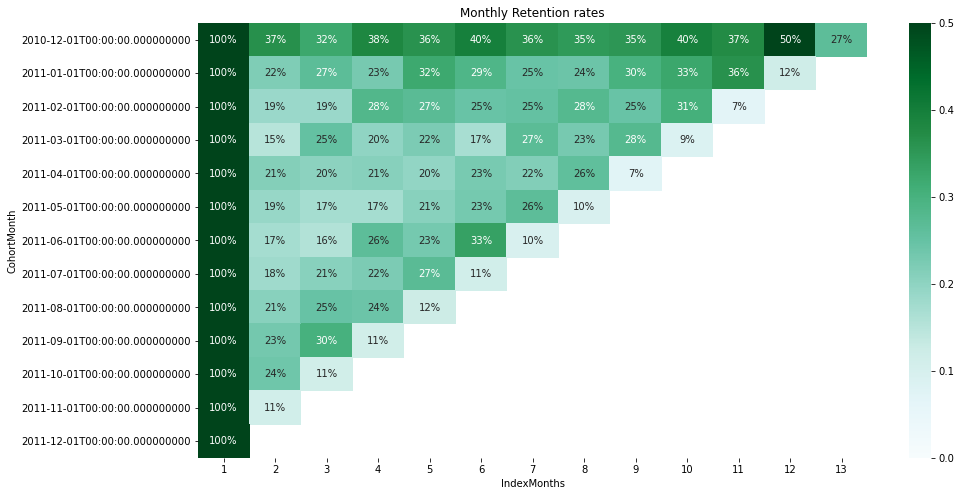

In [25]:
plt.figure(figsize=(15, 8))
plt.title('Monthly Retention rates')
sns.heatmap(data = monthly_retention,
           annot = True,
           fmt = '.0%',
           vmin = 0.0,
           vmax = 0.5,
           cmap = 'BuGn')

plt.show()

#### 2. Average Quantity

In [26]:
#Monthly Average Quantity

cohort_data_month = month_group['Quantity'].mean().reset_index()
average_quantity_mnth = cohort_data_month.pivot(index='CohortMonth',
                                            columns='IndexMonths',
                                            values='Quantity')

average_quantity_mnth.round(3)

IndexMonths,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,12.117,15.670,15.726,15.931,13.625,14.923,16.113,15.638,18.207,17.700,19.047,13.600,15.383
2011-01-01,17.471,13.472,12.708,15.284,12.845,15.389,14.974,14.992,11.629,10.624,9.597,10.184,NaN
2011-02-01,11.202,13.741,19.032,12.046,12.336,12.331,13.571,13.401,10.966,12.416,13.390,NaN,NaN
2011-03-01,9.963,11.741,13.311,10.121,13.756,13.014,13.456,13.851,11.325,9.700,NaN,NaN,NaN
2011-04-01,10.044,10.418,9.773,11.870,11.963,8.692,10.001,9.678,7.567,NaN,NaN,NaN,NaN
2011-05-01,11.457,9.745,14.224,12.758,11.217,8.759,10.764,113.763,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.665,14.727,10.870,13.663,10.690,9.961,9.506,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.921,13.750,7.398,8.178,6.214,7.164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.083,6.199,5.440,6.151,7.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#Daily Average Quantity

cohort_data_days = day_group['Quantity'].mean().reset_index()
average_quantity_days = cohort_data_days.pivot(index='CohortDay',
                                            columns='IndexDays',
                                            values='Quantity')

average_quantity_days.round(2)

IndexDays,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01 01:00:00,12.70,7.35,13.48,NaN,4.67,10.67,10.36,14.44,7.22,7.03,...,19.58,8.23,5.86,NaN,8.85,18.99,10.89,19.79,8.75,22.61
2010-12-02 01:00:00,16.96,NaN,NaN,NaN,63.50,21.91,13.20,12.89,45.70,NaN,...,25.63,36.15,NaN,NaN,13.15,80.44,14.64,13.86,17.67,NaN
2010-12-03 01:00:00,10.55,NaN,5.87,1.86,2.00,NaN,8.03,NaN,NaN,17.50,...,49.00,NaN,4.94,4.67,14.26,6.50,101.32,NaN,NaN,NaN
2010-12-05 01:00:00,6.43,23.56,8.05,30.00,4.00,1.79,NaN,8.83,12.69,3.00,...,4.18,27.12,6.33,7.98,15.85,18.53,NaN,NaN,NaN,NaN
2010-12-06 01:00:00,7.16,3.83,20.83,8.21,3.89,NaN,2.27,8.83,5.03,9.25,...,13.33,21.11,17.37,13.88,18.67,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05 01:00:00,8.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06 01:00:00,10.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07 01:00:00,37.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


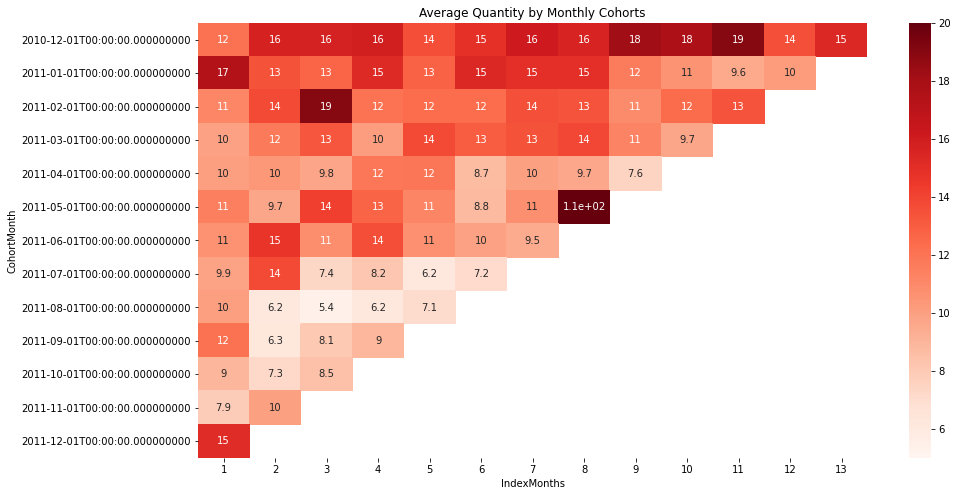

In [28]:
plt.figure(figsize=(15, 8))
plt.title('Average Quantity by Monthly Cohorts')
sns.heatmap(data = average_quantity_mnth,
           annot = True,
            vmin = 5.0,
            vmax = 20.0,
           cmap = 'Reds')

plt.show()

#### 3. Average Price

In [29]:
#Monthly Average Price

cohort_data_month = month_group['TotalPrice'].mean().reset_index()
average_price_mnth = cohort_data_month.pivot(index='CohortMonth',
                                            columns='IndexMonths',
                                            values='TotalPrice')

average_price_mnth.round(3)

IndexMonths,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,22.221,27.271,26.860,27.189,21.192,28.136,28.338,27.431,29.251,33.465,33.993,23.635,25.841
2011-01-01,26.879,25.100,20.968,31.234,22.478,26.280,25.243,25.493,19.074,22.332,19.727,19.781,NaN
2011-02-01,17.868,20.848,21.459,19.363,17.692,16.976,22.166,22.902,18.790,22.184,23.504,NaN,NaN
2011-03-01,17.589,21.140,22.694,18.018,21.106,19.003,22.034,19.990,16.812,13.197,NaN,NaN,NaN
2011-04-01,16.953,21.029,19.493,18.737,19.548,14.999,15.252,15.967,12.343,NaN,NaN,NaN,NaN
2011-05-01,20.483,17.341,22.247,20.897,18.588,14.116,17.018,234.534,NaN,NaN,NaN,NaN,NaN
2011-06-01,23.984,16.286,19.950,20.449,15.345,16.712,13.220,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,14.958,23.532,11.787,13.018,10.885,11.684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,16.522,13.158,12.525,15.883,17.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#Daily Average Price

cohort_data_days = day_group['TotalPrice'].mean().reset_index()
average_price_days = cohort_data_days.pivot(index='CohortDay',
                                            columns='IndexDays',
                                            values='TotalPrice')

average_price_days.round(3)

IndexDays,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01 01:00:00,24.337,21.702,32.444,NaN,9.703,25.110,19.885,20.608,21.254,13.288,...,32.631,14.338,12.774,NaN,12.590,15.526,15.695,35.105,19.197,29.272
2010-12-02 01:00:00,24.401,NaN,NaN,NaN,113.193,41.614,22.031,34.999,108.564,NaN,...,61.389,59.738,NaN,NaN,23.879,222.148,25.272,20.255,38.652,NaN
2010-12-03 01:00:00,20.723,NaN,9.206,3.857,19.900,NaN,18.879,NaN,NaN,194.325,...,82.794,NaN,7.058,5.917,28.374,11.556,83.663,NaN,NaN,NaN
2010-12-05 01:00:00,12.362,59.754,24.328,63.000,11.358,4.020,NaN,14.714,23.557,8.921,...,8.044,54.689,16.038,22.850,47.960,14.749,NaN,NaN,NaN,NaN
2010-12-06 01:00:00,12.980,26.142,33.463,14.295,8.249,NaN,5.790,19.947,9.589,19.656,...,16.241,21.035,19.537,28.171,138.533,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05 01:00:00,6.627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06 01:00:00,10.616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07 01:00:00,89.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


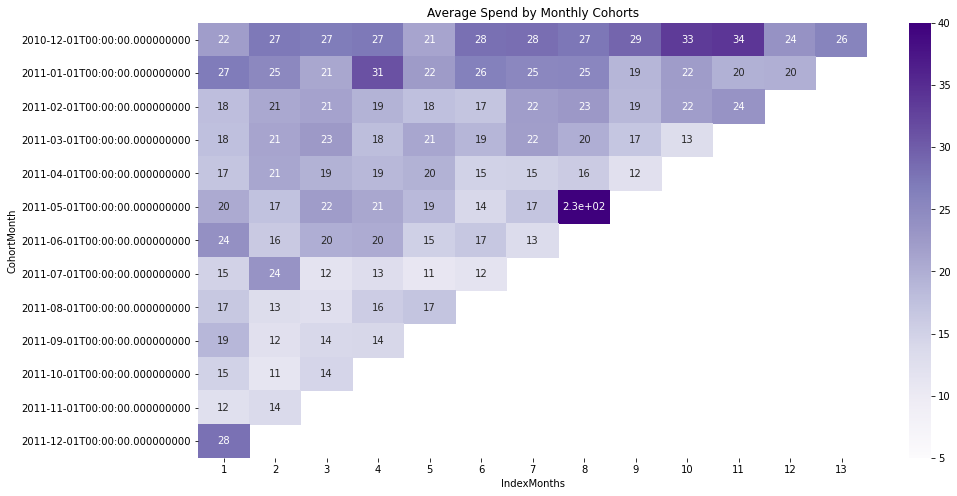

In [31]:
plt.figure(figsize=(15, 8))
plt.title('Average Spend by Monthly Cohorts')
sns.heatmap(data = average_price_mnth,
           annot = True,
            vmin = 5.0,
            vmax = 40.0,
           cmap = 'Purples')

plt.show()

# Project Task 2: Data Modeling - RFM

1. We are now building a RFM (Recency Frequency Monetary) model. Recency means the number of days since a customer made the last purchase. Frequency is the number of purchase in a given period. It could be 3 months, 6 months or 1 year. Monetary is the total amount of money a customer spent in that given period. Therefore, big spenders will be differentiated among other customers such as MVP (Minimum Viable Product) or VIP.

2. We shall then calculate RFM metrics.

3. After that, we'll build RFM Segments. 

##### Note: Rate “recency" for customer who has been active more recently higher than the less recent customer, because each company wants its customers to be recent. We shall also rate “frequency" and “monetary" higher, because the company wants the customer to visit more often and spend more money

Now, we revert to the original dataset `data.df` from which we will create the RFM dataset `rfm_data`

In [32]:
data.df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [33]:
now = dt.datetime(2011, 12, 9, 12, 50)
now

datetime.datetime(2011, 12, 9, 12, 50)

In [34]:
data.df['InvoiceDate'] = pd.to_datetime(data.df['InvoiceDate'])

Now, we shall create the Recency, Frequency and Monetary features from the data

In [35]:
recency_data = data.df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
recency_data.columns = ['CustomerID', 'LastPurchaseDate']
recency_data.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [36]:
recency_data['Recency'] = recency_data['LastPurchaseDate'].apply(lambda x: (now - x).days)
recency_data.drop('LastPurchaseDate', axis=1, inplace=True)
recency_data.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [37]:
frequency_data = data.df.groupby(by='CustomerID', as_index=False)['InvoiceNo'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
frequency_data.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [38]:
monetary_data = data.df.groupby(by='CustomerID', as_index=False).agg({'TotalPrice': 'sum'})
monetary_data.columns = ['CustomerID', 'Monetary']
monetary_data.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [39]:
rf_data = recency_data.merge(frequency_data, on='CustomerID' )
rfm_data = rf_data.merge(monetary_data, on='CustomerID')
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


In [40]:
rfm_data.shape

(4338, 4)

Verifying now by checking `CustomerID`:

In [41]:
data.df[data.df['CustomerID']==12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6


In [42]:
(now - dt.datetime(2011, 1, 18)).days == 325

True

#### Building RFM segments using quartiles

We are dividing the metric into segments for easy understanding and explanation. We will assign scores from 1 to 4 in Recency, Frequency and Monetary data. Here, 1 will be the best value and 4 the lowest value. RFM score therefore becomes an aggregate of the three scores concatenated.

We could also do this in quintiles (5 segments), but that is outside the scope of this project. We do this in `quartiles`

In [43]:
quartiles = rfm_data.quantile(q = [0.25, 0.5, 0.75])
print(quartiles)

quartiles = quartiles.to_dict()
quartiles

      CustomerID  Recency  Frequency   Monetary
0.25    13813.25     17.0       17.0   306.4825
0.50    15299.50     50.0       41.0   668.5700
0.75    16778.75    141.0       98.0  1660.5975


{'CustomerID': {0.25: 13813.25, 0.5: 15299.5, 0.75: 16778.75},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'Monetary': {0.25: 306.48249999999996,
  0.5: 668.5699999999999,
  0.75: 1660.5975000000012}}

Creating now a Segmented RFM table (`rfm_sgmnt`), making note of the fact that high recency is bad, so we assign the top recency score to the customers with the lowest recency numbers, which points to customers who have been more active most recently.


First, we define functions to capture the RFM scores accordingly:

In [44]:
rfm_sgmnt = rfm_data

'''Function arguments: v = value, rfm = RFMscore, q = quartiles(dict))'''
def Rfunction(v, rfm, q):
    if v <= q[rfm][0.25]:
        return 1
    elif v <= q[rfm][0.50]:
        return 2
    elif v <= q[rfm][0.75]:
        return 3
    else:
        return 4

'''Function arguments: v = value, rfm = RFMscore, q = quartiles(dict))'''
def FMfunction(v, rfm, q):
    if v <= q[rfm][0.25]:
        return 4
    elif v <= q[rfm][0.50]:
        return 3
    elif v <= q[rfm][0.75]:
        return 2
    else:
        return 1

In [45]:
rfm_sgmnt['R'] = rfm_sgmnt['Recency'].apply(Rfunction, args=('Recency', quartiles)).map(str)
rfm_sgmnt['F'] = rfm_sgmnt['Frequency'].apply(FMfunction, args=('Frequency', quartiles)).map(str)
rfm_sgmnt['M'] = rfm_sgmnt['Monetary'].apply(FMfunction, args=('Monetary', quartiles)).map(str)

rfm_sgmnt.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346.0,325,1,77183.60,4,4,1
1,12347.0,1,182,4310.00,1,1,1
2,12348.0,74,31,1797.24,3,3,1
3,12349.0,18,73,1757.55,2,2,1
4,12350.0,309,17,334.40,4,4,3


In [46]:
rfm_sgmnt['RFMscore'] = rfm_sgmnt['R'] + rfm_sgmnt['F'] + rfm_sgmnt['M']

rfm_sgmnt.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMscore
0,12346.0,325,1,77183.60,4,4,1,441
1,12347.0,1,182,4310.00,1,1,1,111
2,12348.0,74,31,1797.24,3,3,1,331
3,12349.0,18,73,1757.55,2,2,1,221
4,12350.0,309,17,334.40,4,4,3,443
5,12352.0,35,85,2506.04,2,2,1,221
6,12353.0,203,4,89.00,4,4,4,444
7,12354.0,231,58,1079.40,4,2,2,422
8,12355.0,213,13,459.40,4,4,3,443
9,12356.0,22,59,2811.43,2,2,1,221


The Second Customer is definitely one of the top Customers. Now we sort the dataset to show the top customers with RFM scores of 111. The most valuable customer will be that with RFM 111 and the highest Monetary value, as shown below:

In [47]:
rfm_sgmnt[rfm_sgmnt['RFMscore'] == '111'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMscore
1689,14646.0,1,2076,280206.02,1,1,1,111
4201,18102.0,0,431,259657.30,1,1,1,111
3728,17450.0,7,336,194390.79,1,1,1,111
1879,14911.0,0,5670,143711.17,1,1,1,111
1333,14156.0,9,1395,117210.08,1,1,1,111


This [link](https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales) gives us an idea on how to classify our customers based on their RFM scores. We are going to borrow that idea and call up the number of customers in each segment highlighted. This is just an example of several ways we can segment customers based on their RFM Scores.

In [48]:
best = len(rfm_sgmnt[rfm_sgmnt['RFMscore']=='111'])
loyal = len(rfm_sgmnt[rfm_sgmnt['F']=='1'])
top_spenders = len(rfm_sgmnt[rfm_sgmnt['M']=='1'])
almost_lost = len(rfm_sgmnt[rfm_sgmnt['RFMscore']=='311'])
lost = len(rfm_sgmnt[rfm_sgmnt['RFMscore']=='411'])
lost_cheap = len(rfm_sgmnt[rfm_sgmnt['RFMscore']=='444'])

def segment(x):
    print(('There are {} customers in this segment').format(x))

In [49]:
segment(best)
segment(loyal)
segment(top_spenders)
segment(almost_lost)
segment(lost_cheap)

There are 450 customers in this segment
There are 1080 customers in this segment
There are 1085 customers in this segment
There are 103 customers in this segment
There are 381 customers in this segment


In [50]:
rfm_sgmnt.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,91.536422,90.523744,2048.688081
std,1721.808492,100.014169,225.506968,8985.230220
min,12346.000000,0.000000,1.000000,3.750000
25%,13813.250000,17.000000,17.000000,306.482500
50%,15299.500000,50.000000,41.000000,668.570000
75%,16778.750000,141.000000,98.000000,1660.597500
max,18287.000000,373.000000,7676.000000,280206.020000


Text(0, 0.5, 'Monetary')

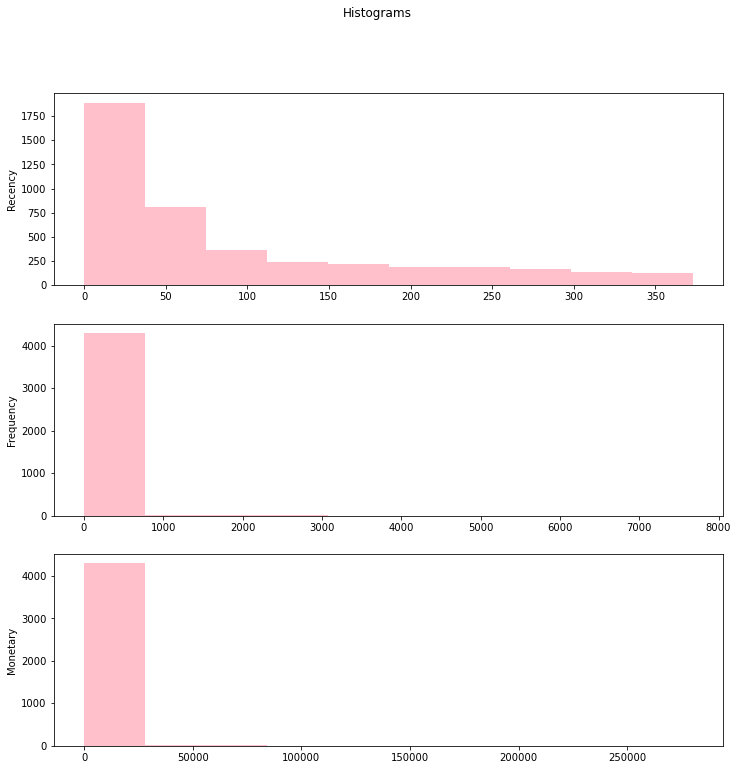

In [51]:
fig, (ax4, ax5, ax6) = plt.subplots(3)
fig.suptitle('Histograms')
rfm_sgmnt.Recency.plot.hist(ax = ax4, figsize = (12,12), color='pink');
rfm_sgmnt.Frequency.sort_values().plot.hist(ax = ax5, color='pink');
rfm_sgmnt.Monetary.sort_values().plot.hist(ax = ax6, color='pink');
ax4.set_ylabel('Recency')
ax5.set_ylabel('Frequency')
ax6.set_ylabel('Monetary')

The Frequency and Monetary values do appear to have outliers, which are causing the data to be skewed. So we shall remove these outliers by sorting these values and cropping off the top 38 values from the dataset, just to view.

Eventually, we shall transform the data, 

The resulting histograms after removing those outliers are shown below:

Text(0, 0.5, 'Monetary')

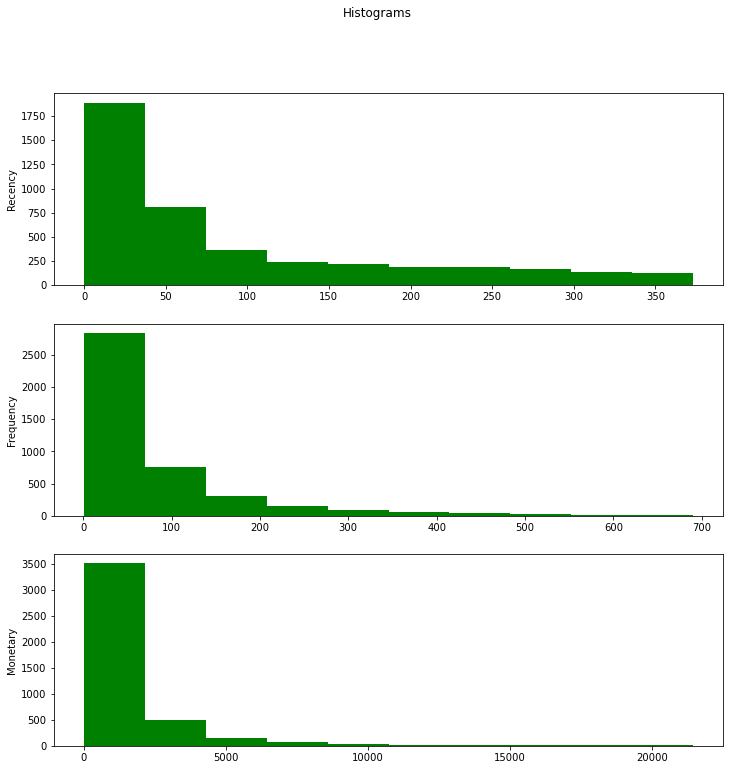

In [52]:
fig, (ax4, ax5, ax6) = plt.subplots(3)
fig.suptitle('Histograms')
rfm_sgmnt.Recency.plot.hist(ax = ax4, figsize = (12,12), color='green');
rfm_sgmnt.Frequency.sort_values().head(4300).plot.hist(ax = ax5, color='green');
rfm_sgmnt.Monetary.sort_values().head(4300).plot.hist(ax = ax6, color='green');
ax4.set_ylabel('Recency')
ax5.set_ylabel('Frequency')
ax6.set_ylabel('Monetary')

Now, we have less skewed data, we can now adjust our table, creating `rfm_adj` by removing those outliers from the `rfm_sgmnt` table

# Project Task 3: Data Modeling - KMeans Clustering

Now we are going to perform KMeans clustering on the dataset. Before we do that, we have to Scale the Data in order to take care of the skewness detected with the visualizations above.

First we define a new dataframe `rfm_adj_raw` to pull out the features we are currently interedted in.Then we standardize that to become `rfm_adj_std`, which we shall fit with the clustering algorithm.

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [54]:
rfm_adj_raw = rfm_sgmnt.loc[:, 'Recency':'Monetary']
rfm_adj_raw.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40


In [55]:
rfm_scores = pd.DataFrame()
rfm_scores['R'] = rfm_sgmnt['Recency'].apply(Rfunction, args=('Recency', quartiles))
rfm_scores['F'] = rfm_sgmnt['Frequency'].apply(FMfunction, args=('Frequency', quartiles))
rfm_scores['M'] = rfm_sgmnt['Monetary'].apply(FMfunction, args=('Monetary', quartiles))

rfm_scores.head()

,R,F,M
0,4,4,1
1,1,1,1
2,3,3,1
3,2,2,1
4,4,4,3


In [56]:
scaler = StandardScaler().fit(rfm_adj_raw)
rfm_adj_std = pd.DataFrame(scaler.transform(rfm_adj_raw), columns=rfm_adj_raw.columns)
rfm_adj_std.head()

,Recency,Frequency,Monetary
0,2.334574,-0.397035,8.363010
1,-0.905340,0.405694,0.251699
2,-0.175360,-0.263986,-0.027988
3,-0.735345,-0.077717,-0.032406
4,2.174578,-0.326075,-0.190812


Now we shall determine the optimal number of clusters to be used for segmenting the customers. We do this by plotting the error (distortions) against a selected range of clusters

In [57]:
distortions = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_adj_std)
    distortions.append(kmeans.inertia_)

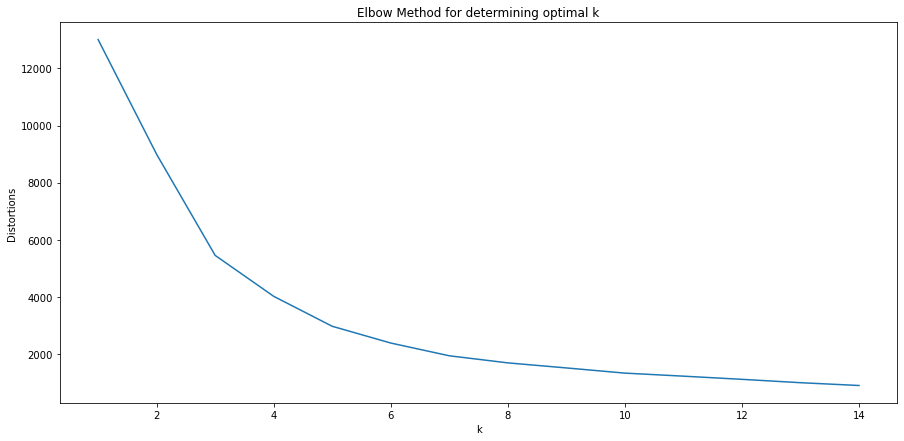

In [58]:
plt.figure(figsize=(15, 7))
plt.plot(K, distortions)
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method for determining optimal k')
plt.show()

In [59]:
error_table = pd.DataFrame(K, distortions)
error_table

,0
13014.000000,1
8989.097983,2
5445.569094,3
4010.300473,4
2959.867450,5
2372.629885,6
1925.465094,7
1676.848642,8
1499.598383,9
1317.724681,10


In [60]:
min(distortions)

883.381202982564

In [61]:
distortions[13]

883.381202982564

In [62]:
model = KMeans(n_clusters=13, random_state=42)
model.fit(rfm_adj_std)
model.labels_.shape

(4338,)

In [63]:
rfm_adj_std.shape

(4338, 3)

In [64]:
rfm_adj_std['Cluster'] = model.labels_
rfm_adj_std['CustomerID'] = rfm_sgmnt['CustomerID']
rfm_adj_std.head()

,Recency,Frequency,Monetary,Cluster,CustomerID
0,2.334574,-0.397035,8.363010,10,12346.0
1,-0.905340,0.405694,0.251699,4,12347.0
2,-0.175360,-0.263986,-0.027988,6,12348.0
3,-0.735345,-0.077717,-0.032406,1,12349.0
4,2.174578,-0.326075,-0.190812,5,12350.0


In [65]:
rfm_adj_std['Profile'] = model.labels_
rfm_adj_std['Profile'].replace({0: "Low",
                                1: "Low",
                                2: "Low",
                                3: "Low",
                                4:"Middle",
                                5: "Middle",
                                6: "Middle",
                                7: "High",
                                8: "High",
                                9: "High",
                                10: "High",
                                11: "High",
                                12: "High"}, inplace = True)

In [66]:
rfm_adj_std.head()

,Recency,Frequency,Monetary,Cluster,CustomerID,Profile
0,2.334574,-0.397035,8.363010,10,12346.0,High
1,-0.905340,0.405694,0.251699,4,12347.0,Middle
2,-0.175360,-0.263986,-0.027988,6,12348.0,Middle
3,-0.735345,-0.077717,-0.032406,1,12349.0,Low
4,2.174578,-0.326075,-0.190812,5,12350.0,Middle


Now, we shall write these fitted data, as well as other dataframes from this notebook to csv files, so we can carry out the next step of this project on Tableau.

In [67]:
rfm_sgmnt.to_csv('output_files/rfm_segments.csv', index=False)
rfm_adj_std.to_csv('output_files/kmeans_profiles.csv', index=False)
retail_data.to_csv('output_files/retail_data.csv', index=False)
error_table.to_csv('output_files/error_table.csv')

# Project Task 4: Data Visualization & Reporting

### Here we shall create a Tableau Dashboard as shown below:

<img src='img/Dashboard.jpg'>